In [2]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from scipy import optimize

### User input and data download

In [6]:
# Tickers:
user_input_str = input()

user_input_list = user_input_str.split(',')

# Remove leading and trailing whitespaces from each string in the list
tickers = [item.strip() for item in user_input_list]

# create the adjusted close price dataframe
adj_close_df = pd.DataFrame()

# populate the dataframe with adjusted close price data of specified assets
for ticker in tickers:
    data = yf.download(ticker, period = "5y", interval = "1d")
    adj_close_df[ticker] = data["Adj Close"]

AAPL,AMZN,SPY,QQQ,TSLA
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Portfolio composition 

In [7]:
## Auxiliary functions
# Portfolio st. dev
def standard_deviation(weights: np.array, cov_matrix: np.array) -> float:
    """Calculates the standard deviation of the portfolio"""
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Expected return
def expected_return(weights: np.array, log_returns: np.array) -> float:
    """Calculates the annulazied Expected return of the portfolio
    as a simple mean of the returns on specified assets"""
    return np.sum(log_returns.mean()*weights)*252

# Sharpe Ratio
def neg_sharpe_ratio(weights: np.array, log_returns: np.array, cov_matrix: np.array, risk_free_rate: float) -> float:
    """Calculates the negative sharpe ratio of the portfolio"""
    return -(expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [8]:
def optimize_portfolio(adj_close_data: , min_weight, max_weight, method, rf_rate = 0.02):
    """"""
    
    # Log returns extraction
    log_returns = np.log(adj_close_data / adj_close_data.shift(1)).dropna()
    
    # Annualized covariance matrix
    cov_matrix = log_returns.cov() * 252
    
    # calculate variables for optimization
    init_weights = np.array([1/log_returns.shape[1]]*log_returns.shape[1])
    df_std_dev = standard_deviation(init_weights, cov_matrix)
    df_exp_return = expected_return(init_weights, returns = log_returns)
    df_sharpe = neg_sharpe_ratio(init_weights, log_returns, cov_matrix, rf_rate)
    
    # Set optimization constraints
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = [(min_weight, max_weight) for _ in range(log_returns.shape[1])]
    
    if method == "max_sharpe":
    # minimize negative sharpe ratio
        optimized_results = optimize.minimize(neg_sharpe_ratio, init_weights,
                    args=(log_returns, cov_matrix, rf_rate), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "min_variance":
        optimized_results = optimize.minimize(
        standard_deviation, init_weights,
        args=(cov_matrix), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "max_exp_return":
        optimized_results = optimize.minimize(expected_return, init_weights,
        args=(log_returns), method='SLSQP', constraints=constraints, bounds=bounds)

    return optimized_results

Optimal Weights:
AAPL: 0.0000
AMZN: 0.4000
SPY: 0.4000
QQQ: 0.2000
TSLA: 0.0000
Expected Annual Return: 0.1525
Expected Volatility: 0.2522
Sharpe Ratio: 0.5256


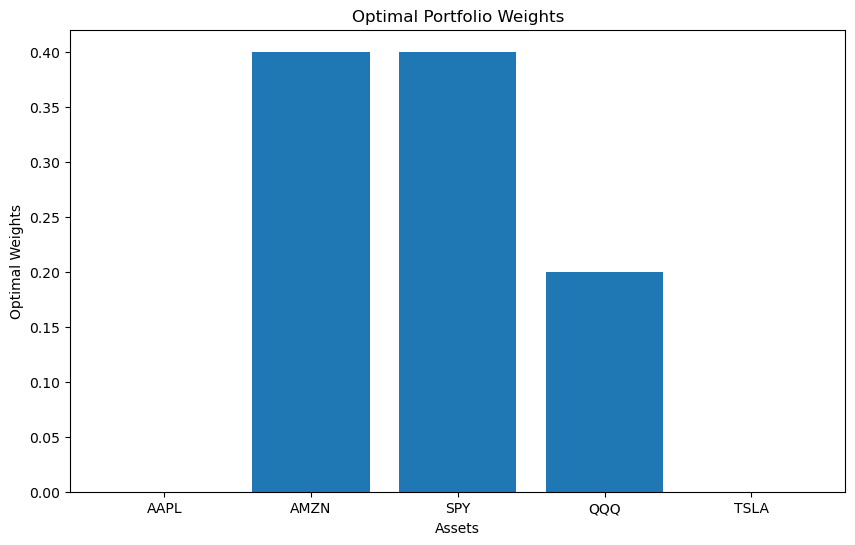

In [9]:
# Auxiliary variables for analysis
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
cov_matrix = log_returns.cov() * 252

# store the optimal portfolio information in a variable
optimal_result = optimize_portfolio(adj_close_df, min_weight = 0.0, max_weight = 0.4, method = "max_exp_return")

## Portfolio analysis

# Extract the weights of assets
optimal_weights = optimal_result.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, returns = log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = -neg_sharpe_ratio(optimal_weights, log_returns, cov_matrix, 0.02)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

# Displaying optimal portfolio
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

1000000


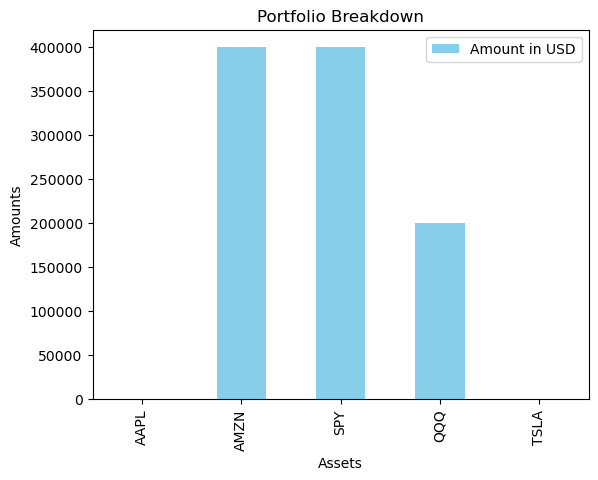

In [10]:
# Portfolio breakdown and value
invested_amount = input()
positions = np.round(optimal_result.x*float(invested_amount))

# Create a portfolio dataframe
portfolio = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions})

# Plot the resulting portfolio
portfolio.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue')
plt.xlabel('Assets')
plt.ylabel('Amounts')
plt.title('Portfolio Breakdown')
plt.show()